# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [0]:
import sys
sys.path.append("..")

In [0]:
#grading
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import re
import requests
import json


class Grader(object):
    def __init__(self, assignment_key, all_parts=()):
        """
        Assignment key is the way to tell Coursera which problem is being submitted.
        """
        self.submission_page = \
            'https://hub.coursera-apps.org/api/onDemandProgrammingScriptSubmissions.v1'
        self.assignment_key = assignment_key
        self.answers = {part: None for part in all_parts}

    def submit(self, email, token):
        submission = {
                    "assignmentKey": self.assignment_key,
                    "submitterEmail": email,
                    "secret": token,
                    "parts": {}
        }
        for part, output in self.answers.items():
            if output is not None:
                submission["parts"][part] = {"output": output}
            else:
                submission["parts"][part] = dict()
        request = requests.post(self.submission_page, data=json.dumps(submission))
        response = request.json()
        if request.status_code == 201:
            print('Submitted to Coursera platform. See results on assignment page!')
        elif u'details' in response and u'learnerMessage' in response[u'details']:
            print(response[u'details'][u'learnerMessage'])
        else:
            print("Unknown response from Coursera: {}".format(request.status_code))
            print(response)

    def set_answer(self, part, answer):
        """Adds an answer for submission. Answer is expected either as string, number, or
           an iterable of numbers.
           Args:
              part - str, assignment part id
              answer - answer to submit. If non iterable, appends repr(answer). If string,
                is appended as provided. If an iterable and not string, converted to
                space-delimited repr() of members.
        """
        if isinstance(answer, str):
            self.answers[part] = answer
        else:
            try:
                self.answers[part] = " ".join(map(repr, answer))
            except TypeError:
                self.answers[part] = repr(answer)


def array_to_grader(array, epsilon=1e-4):
    """Utility function to help preparing Coursera grading conditions descriptions.
    Args:
       array: iterable of numbers, the correct answers
       epslion: the generated expression will accept the answers with this absolute difference with
         provided values
    Returns:
       String. A Coursera grader expression that checks whether the user submission is in
         (array - epsilon, array + epsilon)"""
    res = []
    for element in array:
        if isinstance(element, int):
            res.append("[{0}, {0}]".format(element))
        else:
            res.append("({0}, {1})".format(element - epsilon, element + epsilon))
    return " ".join(res)


In [0]:
#tqdm_utils
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import tqdm
tqdm.monitor_interval = 0  # workaround for https://github.com/tqdm/tqdm/issues/481


class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)

In [0]:
#keras_utils
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from collections import defaultdict
import numpy as np
from keras.models import save_model
import tensorflow as tf
import keras
from keras import backend as K


class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('\nEpoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm_notebook_failsafe(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s


Using TensorFlow backend.


In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import shutil
import requests
import time
from functools import wraps
import traceback


# https://www.saltycrane.com/blog/2009/11/trying-out-retry-decorator-python/
def retry(ExceptionToCheck, tries=4, delay=3, backoff=2):
    def deco_retry(f):

        @wraps(f)
        def f_retry(*args, **kwargs):
            mtries, mdelay = tries, delay
            while mtries > 1:
                try:
                    return f(*args, **kwargs)
                except KeyboardInterrupt as e:
                    raise e
                except ExceptionToCheck as e:
                    print("%s, retrying in %d seconds..." % (str(e), mdelay))
                    traceback.print_exc()
                    time.sleep(mdelay)
                    mtries -= 1
                    mdelay *= backoff
            return f(*args, **kwargs)

        return f_retry  # true decorator

    return deco_retry


@retry(Exception)
def download_file(url, file_path):
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length'))
    bar = tqdm_notebook_failsafe(total=total_size, unit='B', unit_scale=True)
    bar.set_description(os.path.split(file_path)[-1])
    incomplete_download = False
    try:
        with open(file_path, 'wb', buffering=16 * 1024 * 1024) as f:
            for chunk in r.iter_content(4 * 1024 * 1024):
                f.write(chunk)
                bar.update(len(chunk))
    except Exception as e:
        raise e
    finally:
        bar.close()
        if os.path.exists(file_path) and os.path.getsize(file_path) != total_size:
            incomplete_download = True
            os.remove(file_path)
    if incomplete_download:
        raise Exception("Incomplete download")


def download_from_github(version, fn, target_dir):
    url = "https://github.com/hse-aml/intro-to-dl/releases/download/{0}/{1}".format(version, fn)
    file_path = os.path.join(target_dir, fn)
    download_file(url, file_path)


def sequential_downloader(version, fns, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for fn in fns:
        download_from_github(version, fn, target_dir)


def link_all_files_from_dir(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    if not os.path.exists(src_dir):
        # Coursera "readonly/readonly" bug workaround
        src_dir = src_dir.replace("readonly", "readonly/readonly")
    for fn in os.listdir(src_dir):
        src_file = os.path.join(src_dir, fn)
        dst_file = os.path.join(dst_dir, fn)
        if os.name == "nt":
            shutil.copyfile(src_file, dst_file)
        else:
            if os.path.islink(dst_file):
                os.remove(dst_file)
            if not os.path.exists(dst_file):
                os.symlink(os.path.abspath(src_file), dst_file)


def download_all_keras_resources(keras_models, keras_datasets):
    # Originals:
    # http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    # https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    # https://s3.amazonaws.com/img-datasets/mnist.npz
    sequential_downloader(
        "v0.2",
        [
            "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
        ],
        keras_models
    )
    sequential_downloader(
        "v0.2",
        [
            "cifar-10-batches-py.tar.gz",
            "mnist.npz"
        ],
        keras_datasets
    )


def download_week_3_resources(save_path):
    # Originals:
    # http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
    # http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
    sequential_downloader(
        "v0.3",
        [
            "102flowers.tgz",
            "imagelabels.mat"
        ],
        save_path
    )


def download_week_4_resources(save_path):
    # Originals
    # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
    # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
    # http://vis-www.cs.umass.edu/lfw/lfw.tgz
    sequential_downloader(
        "v0.4",
        [
            "lfw-deepfunneled.tgz",
            "lfw.tgz",
            "lfw_attributes.txt"
        ],
        save_path
    )


def download_week_6_resources(save_path):
    # Originals:
    # http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
    sequential_downloader(
        "v0.1",
        [
            "captions_train-val2014.zip",
            "train2014_sample.zip",
            "train_img_embeds.pickle",
            "train_img_fns.pickle",
            "val2014_sample.zip",
            "val_img_embeds.pickle",
            "val_img_fns.pickle"
        ],
        save_path
    )


def link_all_keras_resources():
    link_all_files_from_dir("../readonly/keras/datasets/", os.path.expanduser("~/.keras/datasets"))
    link_all_files_from_dir("../readonly/keras/models/", os.path.expanduser("~/.keras/models"))


def link_week_3_resources():
    link_all_files_from_dir("../readonly/week3/", ".")


def link_week_4_resources():
    link_all_files_from_dir("../readonly/week4/", ".")


def link_week_6_resources():
    link_all_files_from_dir("../readonly/week6/", ".")

In [0]:
#utils
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import queue
import threading
import zipfile
import cv2
import numpy as np
import pickle


def image_center_crop(img):
    h, w = img.shape[0], img.shape[1]
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = 0
    if h > w:
        diff = h - w
        pad_top = diff - diff // 2
        pad_bottom = diff // 2
    else:
        diff = w - h
        pad_left = diff - diff // 2
        pad_right = diff // 2
    return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]


def decode_image_from_buf(buf):
    img = cv2.imdecode(np.asarray(bytearray(buf), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def crop_and_preprocess(img, input_shape, preprocess_for_model):
    img = image_center_crop(img)  # take center crop
    img = cv2.resize(img, input_shape)  # resize for our model
    img = img.astype("float32")  # prepare for normalization
    img = preprocess_for_model(img)  # preprocess for model
    return img


def apply_model(zip_fn, model, preprocess_for_model, extensions=(".jpg",), input_shape=(224, 224), batch_size=32):
    # queue for cropped images
    q = queue.Queue(maxsize=batch_size * 10)

    # when read thread put all images in queue
    read_thread_completed = threading.Event()

    # time for read thread to die
    kill_read_thread = threading.Event()

    def reading_thread(zip_fn):
        zf = zipfile.ZipFile(zip_fn)
        for fn in tqdm_notebook_failsafe(zf.namelist()):
            if kill_read_thread.is_set():
                break
            if os.path.splitext(fn)[-1] in extensions:
                buf = zf.read(fn)  # read raw bytes from zip for fn
                img = decode_image_from_buf(buf)  # decode raw bytes
                img = crop_and_preprocess(img, input_shape, preprocess_for_model)
                while True:
                    try:
                        q.put((os.path.split(fn)[-1], img), timeout=1)  # put in queue
                    except queue.Full:
                        if kill_read_thread.is_set():
                            break
                        continue
                    break

        read_thread_completed.set()  # read all images

    # start reading thread
    t = threading.Thread(target=reading_thread, args=(zip_fn,))
    t.daemon = True
    t.start()

    img_fns = []
    img_embeddings = []

    batch_imgs = []

    def process_batch(batch_imgs):
        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_embeddings = model.predict(batch_imgs)
        img_embeddings.append(batch_embeddings)

    try:
        while True:
            try:
                fn, img = q.get(timeout=1)
            except queue.Empty:
                if read_thread_completed.is_set():
                    break
                continue
            img_fns.append(fn)
            batch_imgs.append(img)
            if len(batch_imgs) == batch_size:
                process_batch(batch_imgs)
                batch_imgs = []
            q.task_done()
        # process last batch
        if len(batch_imgs):
            process_batch(batch_imgs)
    finally:
        kill_read_thread.set()
        t.join()

    q.join()

    img_embeddings = np.vstack(img_embeddings)
    return img_embeddings, img_fns


def save_pickle(obj, fn):
    with open(fn, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def read_pickle(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)

In [0]:
#grading_utils
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import random


def test_vocab(vocab, PAD, UNK, START, END):
    return [
        len(vocab),
        len(np.unique(list(vocab.values()))),
        int(all([_ in vocab for _ in [PAD, UNK, START, END]]))
    ]


def test_captions_indexing(train_captions_indexed, vocab, UNK):
    starts = set()
    ends = set()
    between = set()
    unk_count = 0
    for caps in train_captions_indexed:
        for cap in caps:
            starts.add(cap[0])
            between.update(cap[1:-1])
            ends.add(cap[-1])
            for w in cap:
                if w == vocab[UNK]:
                    unk_count += 1
    return [
        len(starts),
        len(ends),
        len(between),
        len(between | starts | ends),
        int(all([isinstance(x, int) for x in (between | starts | ends)])),
        unk_count
    ]


def test_captions_batching(batch_captions_to_matrix):
    return (batch_captions_to_matrix([[1, 2, 3], [4, 5]], -1, max_len=None).ravel().tolist()
            + batch_captions_to_matrix([[1, 2, 3], [4, 5]], -1, max_len=2).ravel().tolist()
            + batch_captions_to_matrix([[1, 2, 3], [4, 5]], -1, max_len=10).ravel().tolist())


def get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab):
    return {
        decoder.img_embeds: np.random.random((32, IMG_EMBED_SIZE)),
        decoder.sentences: np.random.randint(0, len(vocab), (32, 20))
    }


def test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s):
    tensors_to_test = [
        decoder.h0,
        decoder.word_embeds,
        decoder.flat_hidden_states,
        decoder.flat_token_logits,
        decoder.flat_ground_truth,
        decoder.flat_loss_mask,
        decoder.loss
    ]
    all_shapes = []
    for t in tensors_to_test:
        _ = s.run(t, feed_dict=get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab))
        all_shapes.extend(_.shape)
    return all_shapes


def test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s):
    loss = s.run(decoder.loss, feed_dict=get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab))
    return loss


def test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed):
    np.random.seed(300)
    random.seed(300)
    val_loss = 0
    batches_for_eval = 1000
    for _ in tqdm_notebook_failsafe(range(batches_for_eval)):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed,
                                                       32,
                                                       20))
    val_loss /= 1000.
    return val_loss


In [0]:
#link_all_keras_resources()

In [0]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os

# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [0]:
grader = Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [0]:
# token expires every 30 min
COURSERA_TOKEN = ""
COURSERA_EMAIL = ""

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [0]:
# we downloaded them for you, just link them here
#download_utils.link_week_6_resources()

!wget  http://msvocds.blob.core.windows.net/coco2014/train2014.zip
!wget http://msvocds.blob.core.windows.net/coco2014/val2014.zip
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

--2019-10-09 02:38:59--  http://msvocds.blob.core.windows.net/coco2014/train2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/octet-stream]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  29.6MB/s    in 6m 57s  

2019-10-09 02:45:56 (30.9 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2019-10-09 02:45:59--  http://msvocds.blob.core.windows.net/coco2014/val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/octet-stream]
Saving to: ‘val2014.zip’

val2014.zip         

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [0]:
IMG_SIZE = 299

In [0]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [0]:
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
save_pickle(train_img_embeds, "train_img_embeds.pickle")
save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
save_pickle(val_img_embeds, "val_img_embeds.pickle")
save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))

sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 1s 0us/step


Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [0]:
# load prepared embeddings
train_img_embeds = read_pickle("train_img_embeds.pickle")
train_img_fns = read_pickle("train_img_fns.pickle")
val_img_embeds = read_pickle("val_img_embeds.pickle")
val_img_fns = read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


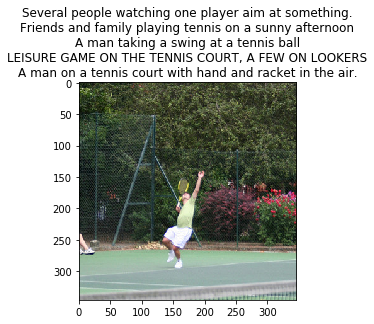

In [0]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = decode_image_from_buf(zf.read(example))
    plt.imshow(image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=122)

# Prepare captions for training

In [0]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
from itertools import chain
from collections import Counter


# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    vocab = [[split_sentence(sentence) for sentence in set_sentence] for set_sentence in train_captions]
    count = [len(vocab[i]) for i in range(len(vocab))]
    vocab = chain.from_iterable(
        [chain.from_iterable(i) for i in vocab])
    vocab=Counter(vocab)
    #vocab = {vocab[i]:vocab.count(vocab[i]) for i in range(len(vocab))}
    #print(vocab)
    #vocab = [vocab[i] for i in range(len(vocab)) if count[i]>=5]
    vocab = [i for i in vocab if vocab[i] >= 5]
    
    
    vocab = vocab+[PAD, UNK, START, END]
    
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res_init = [[split_sentence(sentence) for sentence in set_sentence] for set_sentence in captions]
    res = [[ [vocab[START]]+ [vocab[word] if word in vocab.keys() else vocab[UNK] for word in ind]+[vocab[END]]
           for ind in sentence_set] for sentence_set in res_init]
    ### YOUR CODE HERE ###
    return res

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    columns = max(map(len, batch_captions)) if max_len is None else min(
        max_len, max(map(len, batch_captions)))
    matrix = np.zeros((len(batch_captions),columns))
    matrix.fill(pad_idx)
    for i in range(len(batch_captions)):
        cap_idx = list(batch_captions[i])[:max_len]
        matrix[i,:len(cap_idx)] = cap_idx
    #matrix = ###YOUR CODE HERE###
    return matrix

In [0]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", test_captions_batching(batch_captions_to_matrix))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

TypeError: ignored

In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="images/flatten_help.jpg" style="width:80%">

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    ### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1,LSTM_UNITS])
    ### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    ### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1,])
    ### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.where(tf.equal(flat_ground_truth,tf.constant(pad_idx)),tf.zeros_like(flat_ground_truth),
                              tf.ones_like(flat_ground_truth))
    ### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    #loss = tf.reduce_mean(tf.where(tf.equal(flat_loss_mask, tf.constant(1)),xent,tf.zeros_like(xent) ) )
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))
    #loss = tf.reduce_mean(tf.where(tf.equal(flat_loss_mask, tf.constant(1)),xent) )
    ### YOUR CODE HERE ###

In [0]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [0]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    idx_img=np.random.choice(np.arange(0,images_embeddings.shape[0]),batch_size)
    batch_image_embeddings = images_embeddings[idx_img,:]
    ### YOUR CODE HERE ###
    
    idx_cap =np.random.choice(np.arange(0,5),batch_size)
    batch_captions=indexed_captions[idx_img]
    selected_cap=[caption[n_cap] for caption, n_cap in zip(batch_captions, idx_cap)]
    batch_captions_matrix = batch_captions_to_matrix(selected_cap,pad_idx,max_len)
    ### YOUR CODE HERE ###
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1050
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
#saver.restore(s, os.path.abspath("weights"))

Look at the training and validation loss, they should be decreasing!

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

In [0]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

In [0]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

In [0]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [0]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=225)

In [0]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [0]:
download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

In [0]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a man sitting on a couch with a laptop


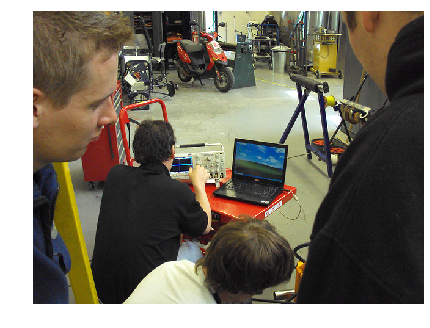

a man holding a nintendo wii controller


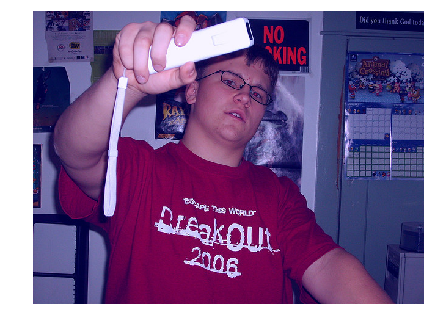

a dog is standing in the grass with a horse


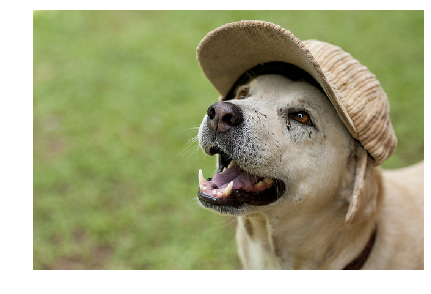

a room with a bed and a television


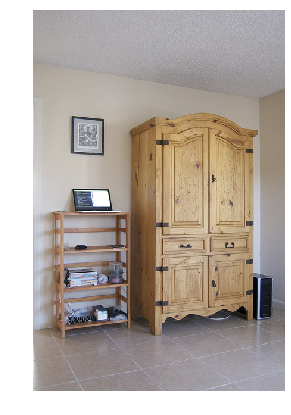

a woman is holding a cell phone while sitting on a bench


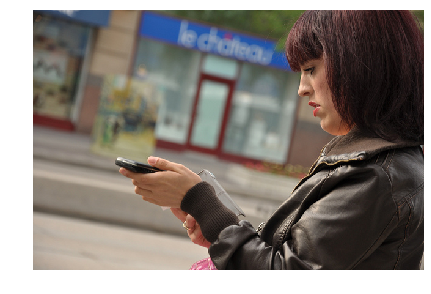

a woman is sitting on a skateboard in the snow


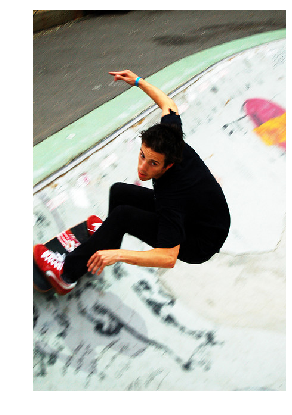

a small brown bear standing on top of a lush green hillside


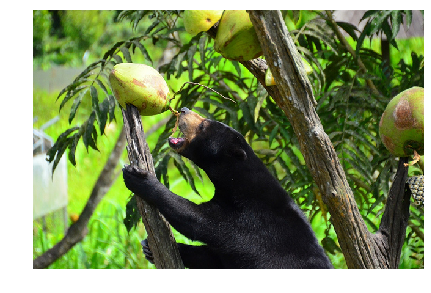

a vase of flowers sitting on a table


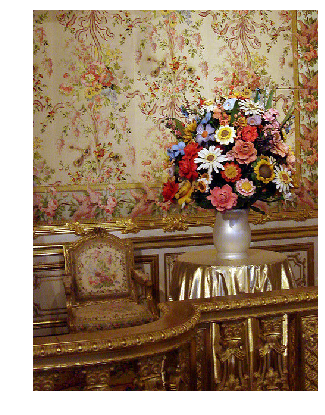

a woman is sitting on a skateboard in the snow


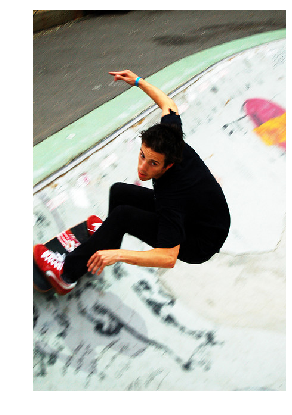

a man in a white shirt is playing tennis


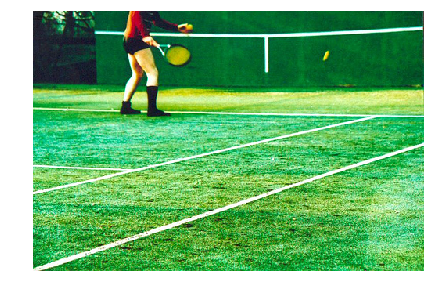

In [0]:
### YOUR EXAMPLES HERE ###
for i in range(10):
  show_valid_example(val_img_fns, example_idx=np.random.randint(0,250))

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!